In [1]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

100%|██████████| 6.90G/6.90G [01:27<00:00, 84.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1


In [2]:
!pip install kagglehub librosa tensorflow scikit-learn joblib

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

# Parameters
sample_rate = 22050  # Audio sampling rate
n_mfcc = 40  # Number of MFCCs
test_size = 0.2  # Fraction for testing
validation_fraction = 0.125  # Fraction of training data for validation
batch_size = 32  # Training batch size
epochs = 30  # Number of training epochs

# Download the Kaggle dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

# Additional train sounds path
new_train_dir = '/content/drive/MyDrive/train_audio_clips'  # Your additional train audio directory

# Combine new train data into Kaggle dataset
def combine_new_train_data(data_dir, new_train_dir):
    train_label_path = os.path.join(data_dir, "train")
    if not os.path.exists(train_label_path):
        os.makedirs(train_label_path)
    for file in os.listdir(new_train_dir):
        source_path = os.path.join(new_train_dir, file)
        destination_path = os.path.join(train_label_path, file)
        if not os.path.exists(destination_path):  # Avoid overwriting
            shutil.copy(source_path, destination_path)  # Copy files instead of renaming

combine_new_train_data(path, new_train_dir)

# Load and preprocess the combined dataset
def load_data(data_dir):
    X = []  # Features
    y = []  # Labels
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    audio, _ = librosa.load(file_path, sr=sample_rate)
                    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
                    mfcc_mean = np.mean(mfcc.T, axis=0)
                    X.append(mfcc_mean)
                    # Assuming any label besides 'train' should be labeled as 'not_train'
                    if label == 'train':
                        y.append('train')
                    else:
                        y.append('not_train')
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y)

# Load data
X, y = load_data(path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_fraction, random_state=42)

# Build the neural network model for binary classification
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Single output neuron with sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Binary cross-entropy loss
    return model

# Build and train the model
input_shape = (X_train.shape[1],)
model = build_model(input_shape)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('audio_train_classifier_model.h5')

# Batch prediction
def batch_classify_audio(file_paths, model, label_encoder):
    for file_path in file_paths:
        classify_audio(file_path, model, label_encoder)

# Classify a new audio file
def classify_audio(file_path, model, label_encoder):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_mean = np.expand_dims(mfcc_mean, axis=0)
        prediction = model.predict(mfcc_mean)
        predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
        print(f"File: {file_path} | Predicted Label: {predicted_label[0]}")
    except Exception as e:
        print(f"Error classifying {file_path}: {e}")

# Example usage
test_audio_files = ['/content/clip_35.wav', '/content/aug_clip_25.wav']  # Add test audio files
batch_classify_audio(test_audio_files, model, label_encoder)


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8149 - loss: 2.5274 - val_accuracy: 0.9783 - val_loss: 0.0714
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9422 - loss: 0.1943 - val_accuracy: 0.9861 - val_loss: 0.0475
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9668 - loss: 0.1171 - val_accuracy: 0.9904 - val_loss: 0.0395
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9779 - loss: 0.0690 - val_accuracy: 0.9878 - val_loss: 0.0365
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9821 - loss: 0.0567 - val_accuracy: 0.9913 - val_loss: 0.0390
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9813 - loss: 0.0512 - val_accuracy: 0.9913 - val_loss: 0.0314
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9895 - loss: 0.0297 - val_accuracy: 0.9913 - val_loss: 0.0348
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9913 - loss: 0.0260 - val_accuracy: 0.

Test Accuracy: 99.74%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
File: /content/clip_35.wav | Predicted Label: train
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
File: /content/aug_clip_25.wav | Predicted Label: train


<ipython-input-4-36650324245f>:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
<ipython-input-4-36650324245f>:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


In [ ]:


# Function to classify an audio file as "train" or "not train"
def classify_train_or_not(file_path, model, label_encoder, sample_rate=22050, n_mfcc=40):
    try:
        # Load the audio file
        audio, _ = librosa.load(file_path, sr=sample_rate)

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

        # Take the mean of the MFCC coefficients across time frames
        mfcc_mean = np.mean(mfcc.T, axis=0)

        # Reshape the feature for the model input
        mfcc_mean = np.expand_dims(mfcc_mean, axis=0)

        # Get the model's prediction
        prediction = model.predict(mfcc_mean)

        # Convert the prediction to a label (0 or 1)
        predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # 0 for 'not train', 1 for 'train'

        # Return the predicted label
        return predicted_label[0]

    except Exception as e:
        print(f"Error classifying {file_path}: {e}")
        return None

# Example usage
file_path = '/content/aug_clip_35.wav'  # Replace with your audio file path
predicted_label = classify_train_or_not(file_path, model, label_encoder)
if predicted_label is not None:
    print(f"Predicted label for {file_path}: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted label for /content/aug_clip_35.wav: not_train


<ipython-input-7-d174407f3b4f>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # 0 for 'not train', 1 for 'train'


In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import kagglehub
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import concurrent.futures

# Parameters
sample_rate = 22050  # Audio sampling rate
n_mfcc = 40  # Number of MFCCs
test_size = 0.2  # Fraction for testing
validation_fraction = 0.125  # Fraction of training data for validation
batch_size = 32  # Training batch size
epochs = 30  # Number of training epochs

# Download the Kaggle dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

# Additional train sounds path
new_train_dir = '/content/drive/MyDrive/train_audio_clips'  # Your additional train audio directory

# Combine new train data into Kaggle dataset
def combine_new_train_data(data_dir, new_train_dir):
    train_label_path = os.path.join(data_dir, "train")
    if not os.path.exists(train_label_path):
        os.makedirs(train_label_path)
    for file in os.listdir(new_train_dir):
        source_path = os.path.join(new_train_dir, file)
        destination_path = os.path.join(train_label_path, file)
        if not os.path.exists(destination_path):  # Avoid overwriting
            shutil.copy(source_path, destination_path)  # Copy files instead of renaming

combine_new_train_data(path, new_train_dir)

# Load and preprocess the combined dataset using parallelism (Joblib)
def preprocess_audio(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_data_parallel(data_dir):
    X = []  # Features
    y = []  # Labels
    file_paths = []

    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_paths.append(os.path.join(folder_path, file))
                # Assuming label encoding happens later

    # Parallel processing of audio files using Joblib
    X = Parallel(n_jobs=-1)(delayed(preprocess_audio)(file_path) for file_path in file_paths)
    # Filter out any None results
    X = [x for x in X if x is not None]

    # Labels (assuming "train" for one class and others as another)
    for label in os.listdir(data_dir):
        if label == "train":
            y.extend(['train'] * len([x for x in file_paths if x.startswith(os.path.join(data_dir, label))]))
        else:
            y.extend(['not_train'] * len([x for x in file_paths if x.startswith(os.path.join(data_dir, label))]))

    return np.array(X), np.array(y)

# Load data
X, y = load_data_parallel(path)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=test_size, random_state=42)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_fraction, random_state=42)

# Use TensorFlow's MirroredStrategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Build the neural network model for binary classification
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Single output neuron with sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Binary cross-entropy loss
    return model

# Build and compile the model inside the strategy scope
with strategy.scope():
    input_shape = (X_train.shape[1],)
    model = build_model(input_shape)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the trained model
model.save('audio_train_classifier_model.h5')

# Batch prediction function (parallelized)
def batch_classify_audio_parallel(file_paths, model, label_encoder):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        executor.map(lambda file_path: classify_audio(file_path, model, label_encoder), file_paths)

# Classify a new audio file
def classify_audio(file_path, model, label_encoder):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        mfcc_mean = np.expand_dims(mfcc_mean, axis=0)
        prediction = model.predict(mfcc_mean)
        predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
        print(f"File: {file_path} | Predicted Label: {predicted_label[0]}")
    except Exception as e:
        print(f"Error classifying {file_path}: {e}")

# Example usage for batch classification
test_audio_files = ['/content/clip_35.wav', '/content/aug_clip_20.wav']  # Add test audio files
batch_classify_audio_parallel(test_audio_files, model, label_encoder)


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1
Number of devices: 1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8395 - loss: 1.7093 - val_accuracy: 0.9687 - val_loss: 0.0834
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9586 - loss: 0.1470 - val_accuracy: 0.9878 - val_loss: 0.0461
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9756 - loss: 0.0755 - val_accuracy: 0.9904 - val_loss: 0.0315
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9828 - loss: 0.0501 - val_accuracy: 0.9913 - val_loss: 0.0284
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9882 - loss: 0.0362 - val_accuracy: 0.9948 - val_loss: 0.0291
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9902 - loss: 0.0319 - val_accuracy: 0.9939 - val_loss: 0.0331
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9918 - loss: 0.0223 - val_accuracy: 0.9939 - val_loss: 0.0296
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9902 - loss: 0.0305 - val_accuracy: 0.

Test Accuracy: 99.74%
Error classifying /content/aug_clip_20.wav: [Errno 2] No such file or directory: '/content/aug_clip_20.wav'


<ipython-input-8-9df374f5d1e5>:137: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(file_path, sr=sample_rate)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
File: /content/clip_35.wav | Predicted Label: train


<ipython-input-8-9df374f5d1e5>:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


In [ ]:
import time

# Measure time for the non-parallel model (original code)
start_time = time.time()

# Train the non-parallel model
history_baseline = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

end_time = time.time()
training_time_baseline = end_time - start_time

# Evaluate the non-parallel model
start_time = time.time()
loss_baseline, accuracy_baseline = model.evaluate(X_test, y_test)
end_time = time.time()
evaluation_time_baseline = end_time - start_time

print(f"Non-Parallel Model Accuracy: {accuracy_baseline * 100:.2f}%")
print(f"Non-Parallel Model Training Time: {training_time_baseline:.2f} seconds")
print(f"Non-Parallel Model Evaluation Time: {evaluation_time_baseline:.2f} seconds")

# Measure time for the parallel model (with Joblib + MirroredStrategy)
start_time = time.time()

# Train the parallel model (inside strategy scope)
with strategy.scope():
    history_parallel = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)

end_time = time.time()
training_time_parallel = end_time - start_time

# Evaluate the parallel model
start_time = time.time()
loss_parallel, accuracy_parallel = model.evaluate(X_test, y_test)
end_time = time.time()
evaluation_time_parallel = end_time - start_time

print(f"Parallel Model Accuracy: {accuracy_parallel * 100:.2f}%")
print(f"Parallel Model Training Time: {training_time_parallel:.2f} seconds")
print(f"Parallel Model Evaluation Time: {evaluation_time_parallel:.2f} seconds")


Epoch 1/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9976 - loss: 0.0100 - val_accuracy: 0.9948 - val_loss: 0.0507
Epoch 2/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9948 - val_loss: 0.0344
Epoch 3/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9981 - loss: 0.0052 - val_accuracy: 0.9948 - val_loss: 0.0357
Epoch 4/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9948 - val_loss: 0.0424
Epoch 5/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9983 - loss: 0.0051 - val_accuracy: 0.9957 - val_loss: 0.0406
Epoch 6/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9957 - val_loss: 0.0389
Epoch 7/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9998 - loss: 8.1333e-04 - val_accuracy: 0.9957 - val_loss: 0.0545
Epoch 8/30
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9967 - loss: 0.0110 - val_accurac

In [ ]:
# Example test audio files for prediction comparison
test_audio_files = ['/content/clip_35.wav', '/content/aug_clip_6.wav']

# Batch classify using non-parallel model
print("Predictions from Non-Parallel Model:")
batch_classify_audio(test_audio_files, model, label_encoder)

# Batch classify using parallel model
print("Predictions from Parallel Model:")
batch_classify_audio_parallel(test_audio_files, model, label_encoder)


Predictions from Non-Parallel Model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
File: /content/clip_35.wav | Predicted Label: train


<ipython-input-8-9df374f5d1e5>:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
File: /content/aug_clip_6.wav | Predicted Label: not_train
Predictions from Parallel Model:


<ipython-input-8-9df374f5d1e5>:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
File: /content/aug_clip_6.wav | Predicted Label: not_train
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
File: /content/clip_35.wav | Predicted Label: train


<ipython-input-8-9df374f5d1e5>:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label
<ipython-input-8-9df374f5d1e5>:142: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = label_encoder.inverse_transform([int(prediction > 0.5)])  # Convert probability to label


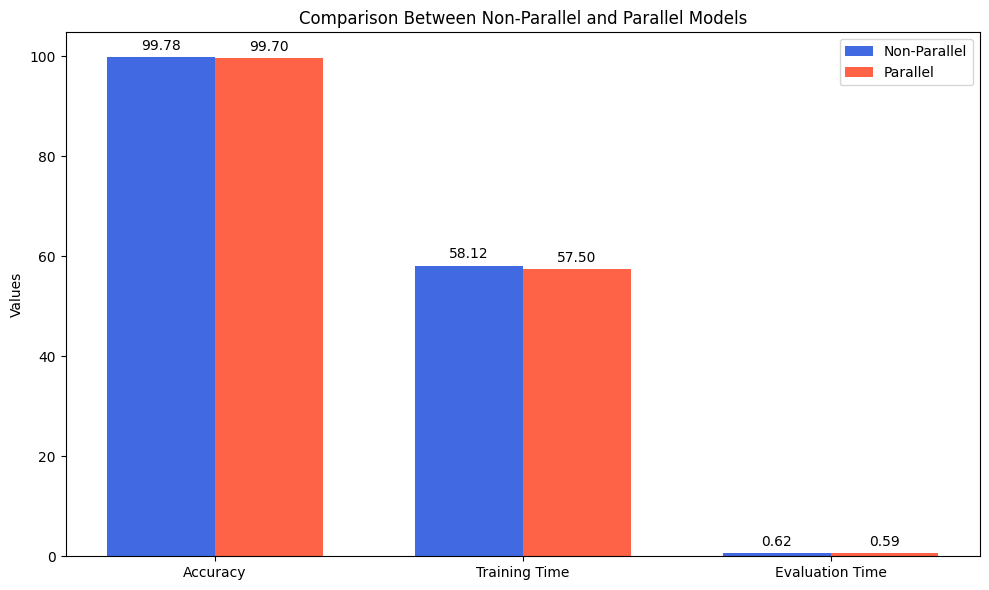

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for visualization
metrics = ['Accuracy', 'Training Time', 'Evaluation Time']
non_parallel_metrics = [accuracy_baseline * 100, training_time_baseline, evaluation_time_baseline]
parallel_metrics = [accuracy_parallel * 100, training_time_parallel, evaluation_time_parallel]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bar chart
rects1 = ax.bar(x - width / 2, non_parallel_metrics, width, label='Non-Parallel', color='royalblue')
rects2 = ax.bar(x + width / 2, parallel_metrics, width, label='Parallel', color='tomato')

ax.set_ylabel('Values')
ax.set_title('Comparison Between Non-Parallel and Parallel Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Autolabeling function for bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()


In [ ]:
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Disk Usage: {psutil.disk_usage('/').percent}%")


CPU Usage: 62.5%
Disk Usage: 44.3%


Path to dataset files: /root/.cache/kagglehub/datasets/janboubiabderrahim/vehicle-sounds-dataset/versions/1
Non-parallel processing time: 387.71 seconds
Parallel processing time: 227.99 seconds


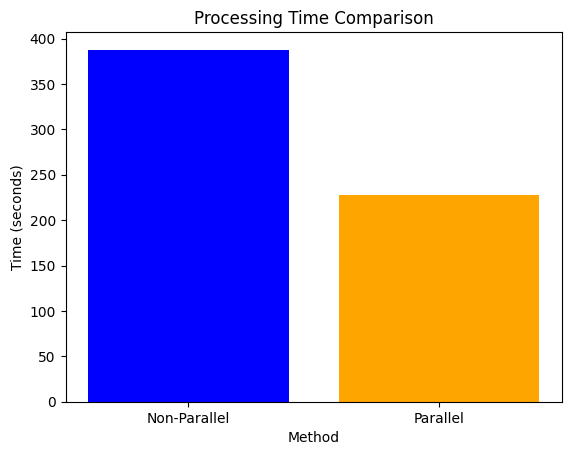

In [1]:
import os
import numpy as np
import librosa
import time
from joblib import Parallel, delayed
import concurrent.futures
import shutil
import kagglehub

# Parameters
sample_rate = 22050  # Audio sampling rate
n_mfcc = 40  # Number of MFCCs
test_size = 0.2  # Fraction for testing
validation_fraction = 0.125  # Fraction of training data for validation
batch_size = 32  # Training batch size
epochs = 30  # Number of training epochs

# Download the Kaggle dataset
path = kagglehub.dataset_download("janboubiabderrahim/vehicle-sounds-dataset")
print("Path to dataset files:", path)

# Additional train sounds path
new_train_dir = '/content/drive/MyDrive/train_audio_clips'  # Your additional train audio directory

# Combine new train data into Kaggle dataset
def combine_new_train_data(data_dir, new_train_dir):
    train_label_path = os.path.join(data_dir, "train")
    if not os.path.exists(train_label_path):
        os.makedirs(train_label_path)
    for file in os.listdir(new_train_dir):
        source_path = os.path.join(new_train_dir, file)
        destination_path = os.path.join(train_label_path, file)
        if not os.path.exists(destination_path):  # Avoid overwriting
            shutil.copy(source_path, destination_path)  # Copy files instead of renaming

combine_new_train_data(path, new_train_dir)

# Preprocess audio file (non-parallel)
def preprocess_audio(file_path):
    try:
        audio, _ = librosa.load(file_path, sr=sample_rate)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc.T, axis=0)
        return mfcc_mean
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Load and preprocess the combined dataset (non-parallel)
def load_data_non_parallel(data_dir):
    X = []  # Features
    y = []  # Labels
    file_paths = []

    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_paths.append(os.path.join(folder_path, file))
                # Assuming label encoding happens later

    # Non-parallel processing
    for file_path in file_paths:
        mfcc_mean = preprocess_audio(file_path)
        if mfcc_mean is not None:
            X.append(mfcc_mean)
            # Labels (assuming "train" for one class and others as another)
            if file_path.startswith(os.path.join(data_dir, "train")):
                y.append('train')
            else:
                y.append('not_train')

    return np.array(X), np.array(y)

# Load and preprocess the combined dataset (parallel)
def load_data_parallel(data_dir):
    X = []  # Features
    y = []  # Labels
    file_paths = []

    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_paths.append(os.path.join(folder_path, file))
                # Assuming label encoding happens later

    # Parallel processing using Joblib
    X = Parallel(n_jobs=-1)(delayed(preprocess_audio)(file_path) for file_path in file_paths)
    X = [x for x in X if x is not None]

    # Labels (assuming "train" for one class and others as another)
    for label in os.listdir(data_dir):
        if label == "train":
            y.extend(['train'] * len([x for x in file_paths if x.startswith(os.path.join(data_dir, label))]))
        else:
            y.extend(['not_train'] * len([x for x in file_paths if x.startswith(os.path.join(data_dir, label))]))

    return np.array(X), np.array(y)

# Measure time taken for non-parallel processing
start_time = time.time()
X_non_parallel, y_non_parallel = load_data_non_parallel(path)
non_parallel_time = time.time() - start_time
print(f"Non-parallel processing time: {non_parallel_time:.2f} seconds")

# Measure time taken for parallel processing
start_time = time.time()
X_parallel, y_parallel = load_data_parallel(path)
parallel_time = time.time() - start_time
print(f"Parallel processing time: {parallel_time:.2f} seconds")

# Compare performance visually (Optional, requires matplotlib)
import matplotlib.pyplot as plt

times = [non_parallel_time, parallel_time]
labels = ['Non-Parallel', 'Parallel']

plt.bar(labels, times, color=['blue', 'orange'])
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.title('Processing Time Comparison')
plt.show()
